Inertia (Within-cluster sum of squares): 129.31
Silhouette Score: 0.47


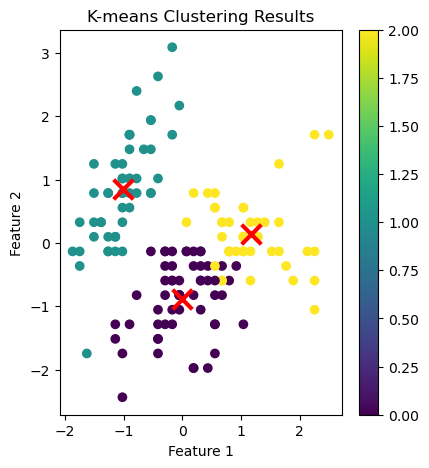

In [2]:
import numpy as np
from sklearn.datasets import load_iris
import matplotlib.pyplot as plt

class KMeans:
    def __init__(self, n_clusters=3, max_iters=100, random_state=None):
        self.n_clusters = n_clusters
        self.max_iters = max_iters
        self.random_state = random_state
        self.centroids = None
        self.labels = None
        
    def fit(self, X):
        # Set random seed for reproducibility
        if self.random_state is not None:
            np.random.seed(self.random_state)
        
        # Randomly initialize centroids
        idx = np.random.choice(len(X), self.n_clusters, replace=False)
        self.centroids = X[idx]
        
        for _ in range(self.max_iters):
            # Store old centroids
            old_centroids = self.centroids.copy()
            
            # Assign points to nearest centroid
            self.labels = self._assign_clusters(X)
            
            # Update centroids
            for k in range(self.n_clusters):
                if sum(self.labels == k) > 0:  # Ensure cluster is not empty
                    self.centroids[k] = np.mean(X[self.labels == k], axis=0)
            
            # Check convergence
            if np.all(old_centroids == self.centroids):
                break
                
        return self
    
    def _assign_clusters(self, X):
        # Calculate distances to all centroids for each point
        distances = np.sqrt(((X - self.centroids[:, np.newaxis])**2).sum(axis=2))
        # Assign each point to nearest centroid
        return np.argmin(distances, axis=0)
    
    def predict(self, X):
        return self._assign_clusters(X)
    
    def inertia(self, X):
        """Calculate within-cluster sum of squares"""
        distances = np.sqrt(((X - self.centroids[self.labels])**2).sum(axis=1))
        return np.sum(distances)

def standardize_data(X):
    """Standardize features to zero mean and unit variance"""
    mean = np.mean(X, axis=0)
    std = np.std(X, axis=0)
    return (X - mean) / std

def silhouette_score(X, labels):
    """Calculate silhouette score for clustering evaluation"""
    n_samples = len(X)
    silhouette_vals = np.zeros(n_samples)
    
    for i in range(n_samples):
        # Get all points in same cluster (cluster_i)
        cluster_i = labels[i]
        points_in_cluster_i = X[labels == cluster_i]
        
        # Calculate a(i): mean distance to points in same cluster
        if len(points_in_cluster_i) > 1:
            a_i = np.mean(np.sqrt(np.sum((points_in_cluster_i - X[i])**2, axis=1)))
        else:
            a_i = 0
            
        # Calculate b(i): mean distance to points in next nearest cluster
        b_i = float('inf')
        for cluster_j in set(labels):
            if cluster_j != cluster_i:
                points_in_cluster_j = X[labels == cluster_j]
                b_ij = np.mean(np.sqrt(np.sum((points_in_cluster_j - X[i])**2, axis=1)))
                b_i = min(b_i, b_ij)
        
        # Calculate silhouette score for point i
        if a_i == 0 and b_i == 0:
            silhouette_vals[i] = 0
        else:
            silhouette_vals[i] = (b_i - a_i) / max(a_i, b_i)
    
    return np.mean(silhouette_vals)

# Load and preprocess data
iris = load_iris()
X = iris.data
X_standardized = standardize_data(X)

# Initialize and fit KMeans
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(X_standardized)

# Calculate metrics
inertia = kmeans.inertia(X_standardized)
silhouette = silhouette_score(X_standardized, kmeans.labels)

# Visualize results (using first two features)
plt.figure(figsize=(10, 5))

# Scatter plot
plt.subplot(1, 2, 1)
scatter = plt.scatter(X_standardized[:, 0], X_standardized[:, 1], 
                     c=kmeans.labels, cmap='viridis')
plt.scatter(kmeans.centroids[:, 0], kmeans.centroids[:, 1], 
           c='red', marker='x', s=200, linewidths=3)
plt.title('K-means Clustering Results')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.colorbar(scatter)

# Print evaluation metrics
print(f"Inertia (Within-cluster sum of squares): {inertia:.2f}")
print(f"Silhouette Score: {silhouette:.2f}")